# Práctica 3.2: Clustering

<center><h3>
    David Pacios Vazquez
</h3></center>

## Instrucións

Isto é un **Jupyter Notebook**, un documento que integra código Python nun arquivo Markdown.
Isto permítenos, ir exexutando celdas de código pouco a pouco, así como xerar automáticamente un informe ben formateado da práctica.

Podes engadir unha celda co botón **"Insert"** da barra de ferramentas, e cambiar seu tipo con **"Cell > Cell Type"**

Para executar unha celda de código, seleccionarémola e pulsaremos a botón **"▶ Run"** da barra de ferramentas.
Para pasar o documento a HTML, seleccionaremos **"File > Download as > HTML (.html)"**

Segue este guión ata o final. Executa o código proporcionado paso a paso comprendendo o que estás a facer e reflexionando sobre os resultados. Haberá preguntas intercaladas ao longo do guión, responde a todas elas na sección reservada para ese fin: **"Respostas ao cuestionario"**. Por favor, non modifiques ningunha liña de código agás cando se che pida explícitamente.

Non esquezas insertar o teu **nome e apelidos** na celda superior.

## Entrega da práctica

A data límite de entrega será a indicada no Campus Virtual. A entrega consistirá nun único arquivo comprimido co nome `APELIDOS_NOME_Clustering.zip` que conteña os seguintes ficheiros:

 * `APELIDOS_NOME_Clustering.html`: Arquivo HTML froito da exportación do presente Notebook, coas preguntas respondidas ao final do documento.
 * `APELIDOS_NOME_Clustering.ipynb`: Arquivo Jupyter Notebook fonte.
 * Arquivo de datos do problema de libre elección.

## Números aleatorios

<span style="color:red">**MOI IMPORTANTE:**</span> Vamos a establecer un *seed* cun valor predefinido inmediatamente antes de executar calquera operación cun compoñente aleatorio. Así nos aseguraremos de que os nosos resultados sexan repetibles.

Isto é, imos poñer `np.random.seed(SEED_VALUE)` antes de:
 - `train_test_split()`
 - `fit()`
 - `predict()`
 
Tamén imos poñer `random_state=SEED_VALUE` en aquelas funcións que o admitan (coma o construtor de `KMeans`).

Haberá ocasión nas que isto sexa excesivo, pero así curámonos en despistes.

# Introdución

Nesta práctica imos reforzar os conceptos vistos nas clases teóricas sobre aprendizaxe non supervisada. Comezaremos traballando sobre un conxunto de datos xa coñecido, o da superficie e prezo das vivendas, sobre o cal aplicaremos o algoritmo **k-means**. O segundo exercicio consistirá en aplicar clustering a un problema de libre elección.

# Clustering sobre o dataset das vivendas

Na práctica anterior fomos capaces de dar un prezo estimado das vivendas a partir da súa superficie. Agora imos usar as dúas variables, superficie e prezo, para buscar novas relacións entre os nosos datos e facer unha distinción en varias categorías de vivendas.

Cargamos os datos empregando a función `read_csv()`:

In [155]:
import pandas as pd  # Importamos a librería (isto sólo é necesario facelo unha vez)

vivendas = pd.read_csv('vivendas.csv',  # Cargamos o csv
                       delimiter=',',
                       header=0)

Nesta práctica non vai ser preciso dividir os datos en dous conxuntos (adestramento e test), xa que o que queremos atopar son **novas** relacións. Isto implica tamén que non vai haber ningunha etapa de validación de modelos. En lugar diso, o que se adoita facer é unha etapa de análise e interpretación dos agrupamentos obtidos.

## Agrupamento empregando funcións propias

___K-means___ é un algoritmo de clasificación non supervisada (*clustering*) que agrupa os exemplos dun conxunto de datos en $k$ grupos baseándose nas súas características. O agrupamento realízase minimizando a suma de distancias (habitualmente distancia cadrática) entre cada exemplo e o centroide do grupo (*cluster*) ao que foi asignado. 

O algoritmo consta de 3 etapas diferenciadas:

1. **Inicialización**: unha vez escollido o número de grupos $k$, establécense aleatoriamente $k$ centroides no espazo de datos.
2. **Asignación dos exemplos aos centroides**: cada instancia do dataset é asignada ao seu centroide máis próximo.
3. **Actualización dos centroides**: para cada grupo, actualízase a posición do centroide tomando como novo centroide a posición media dos exemplos pertenecentes a dito grupo.
 
Os pasos 2 e 3 repítense durante $n$ iteracións. O algoritmo resolve un problema de optimización, sendo a función a optimizar (minimizar) a suma das distancias cadráticas de cada exemplo ao centroide do seu cluster.
 
Imos empregar as seguintes funcións:

In [156]:
import numpy as np

# Función de distancia cadrática
def calcula_distancias(a, b):
    matriz_distancias = np.empty([a.shape[0], b.shape[0]])
    # Calculamos a distancia punto a punto dos conxuntos a e b
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            dist = a[i] - b[j]
            matriz_distancias[i, j] = dist[0] ** 2 + dist[1] ** 2
    
    return matriz_distancias

# Función a optimizar J
def j(x, centroides, clusters):
    # Obtemos a distancia de cada punto ao seu cluster
    distancias = x - centroides[clusters]
    # Calculamos o custo formula dispositiva 7 del temario
    custo = 1.0/x.shape[0] * sum((np.sqrt(distancias[:, 0]**2 + distancias[:,1]**2))**2)
    return custo

# Función de actualización de centroides
def actualiza_centr(x, clusters, centroides):
    for i in range(centroides.shape[0]):
        #Todos los puntos que pertecen al cluster/centro
        """
        for j in range(x):
            if cluster[j] == i:
                x_cluster.append(x[j])
        """
        x_cluster_i = x[clusters==i]
        #Mover el centro segun el punto medio de todos los puntos que pertenecen al centroide
        centroides[i] = np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0] 
    return centroides

# Función de clustering k-means
def k_medias(x, centroides, iteracions):
    hist_clusters = []
    hist_centroides = []
    hist_custo = []
    
    for i in range(iteracions):
        dist_centroides = calcula_distancias(x, centroides)
        clusters = np.argmin(dist_centroides, axis=1)#Devuelve la posicion donde esta la distancia mínima
        centroides = actualiza_centr(x, clusters, centroides)
        custo = j(x, centroides, clusters)
        # Gardamos o historial de cada iteración
        hist_clusters.append(clusters)
        hist_centroides.append(centroides.copy())
        hist_custo.append(custo)
    
    return {'custo': hist_custo, 'clusters': hist_clusters, 'centroides': hist_centroides}

Xa podemos realizar un primeiro agrupamento. Convertemos o dataset a unha matriz porque neste caso facilítanos as operacións:

In [157]:
vivendas_mat = vivendas.values

Tomamos 3 exemplos ao azar como centroides iniciais (non debemos esquecernos de definir unha semente para que os resultados sexan reptibles):

In [158]:
SEED_VALUE = 190463  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados

np.random.seed(SEED_VALUE)
centr_iniciais = vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]
centr_iniciais

array([[210.  , 299.9 ],
       [106.  , 104.96],
       [ 76.  ,  80.15]])

Invocamos o método `k_medias`:

In [159]:
# Definimos o número de iteracións do algoritmo
n_iter = 20
# Invocamos o método k_medias
agrupamento_1 = k_medias(vivendas_mat, centr_iniciais, n_iter)

A variable `agrupamento_1` almacena o historial de custos, os centroides e as asignacións de cada exemplo aos 3 clusters en todas as iteracións. Aquí tes algúns exemplos da información á que podes acceder:

In [160]:
# Custo trala primeira iteración
agrupamento_1['custo'][0]

3649.4144836282358

In [161]:
# Custo final
agrupamento_1['custo'][n_iter-1]

2072.6093651192277

In [162]:
# Centroides na iteración 4
agrupamento_1['centroides'][3]

array([[208.57142857, 351.38357143],
       [126.61538462, 157.60307692],
       [ 93.87878788,  86.56242424]])

In [163]:
# Asignación dos 6 primeiros exemplos do dataset aos clusters na última iteración
agrupamento_1['clusters'][n_iter-1][:6]

array([2, 1, 1, 2, 1, 2])

Imos graficar paso a paso como foi converxendo o algoritmo para chegar ao agrupamento definitivo:

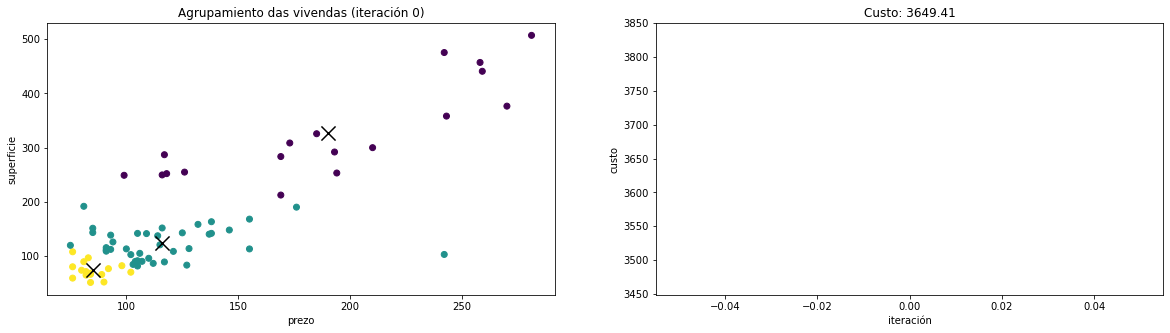

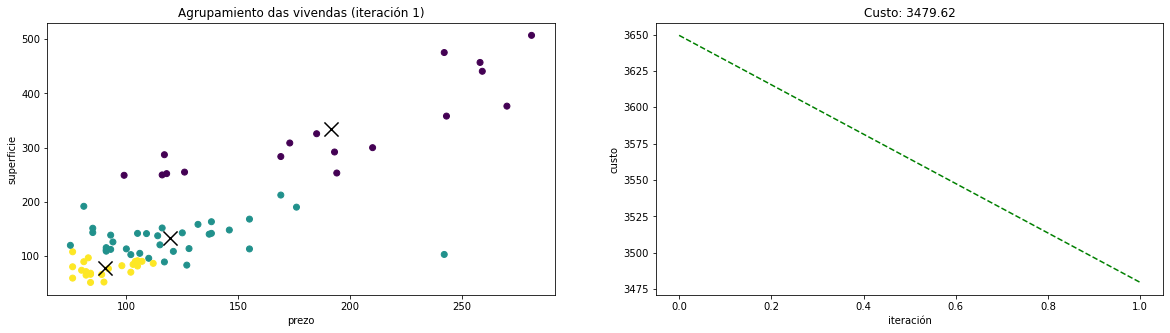

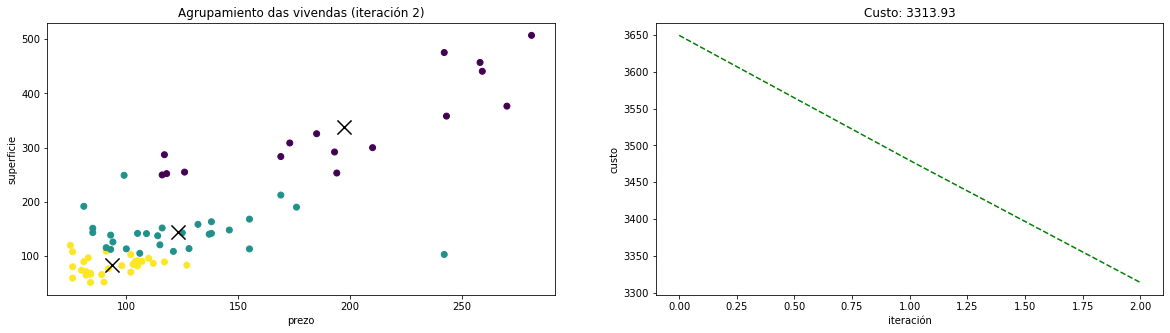

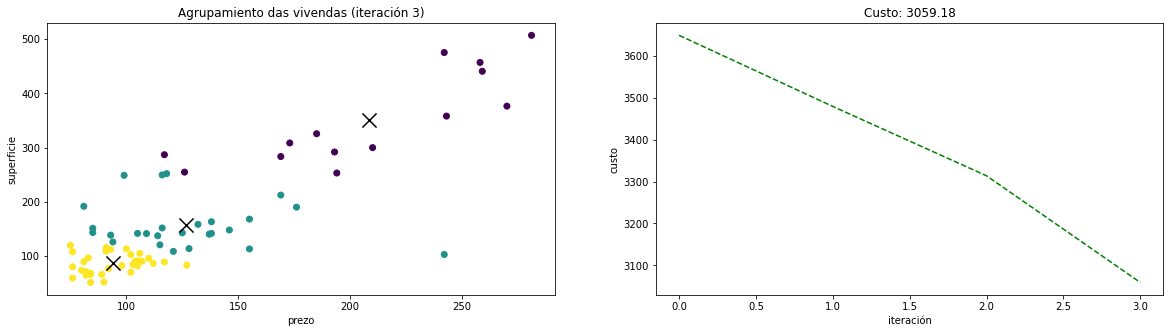

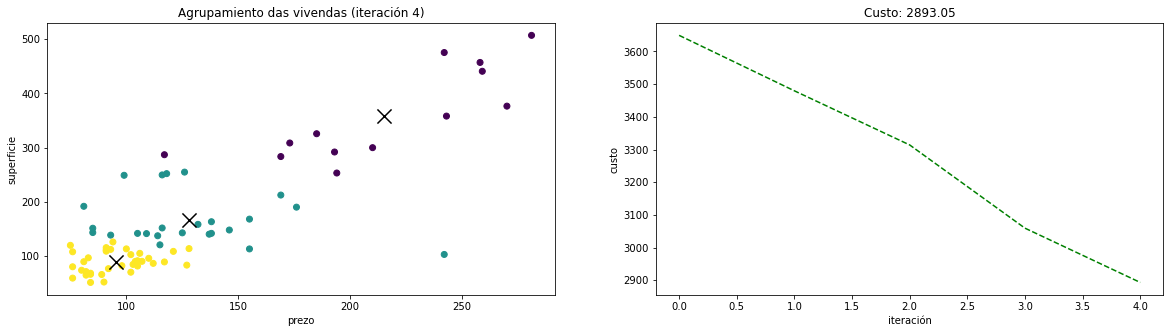

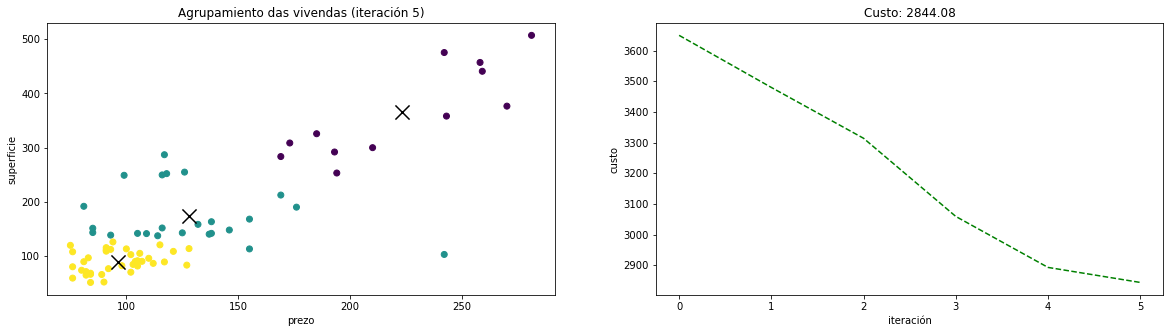

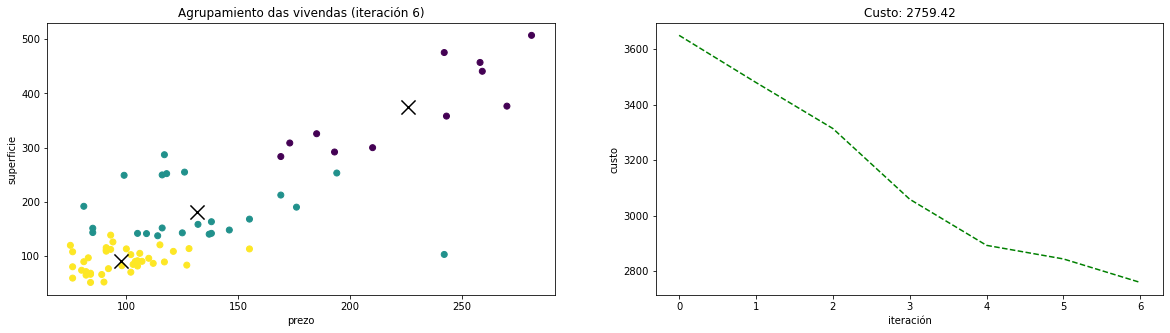

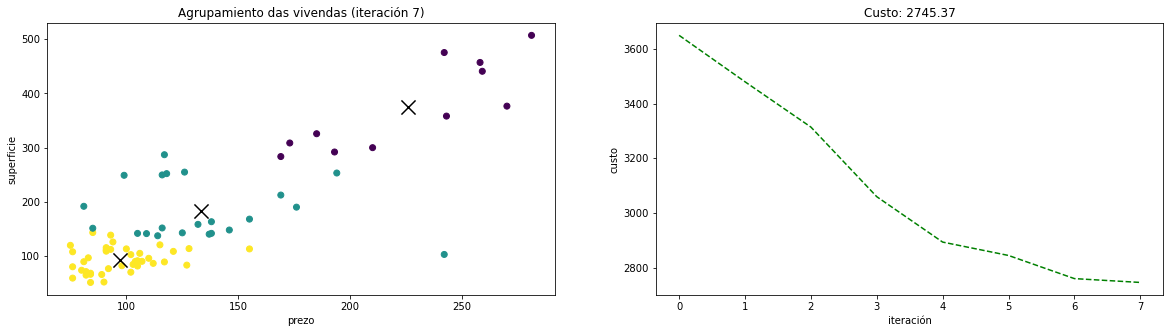

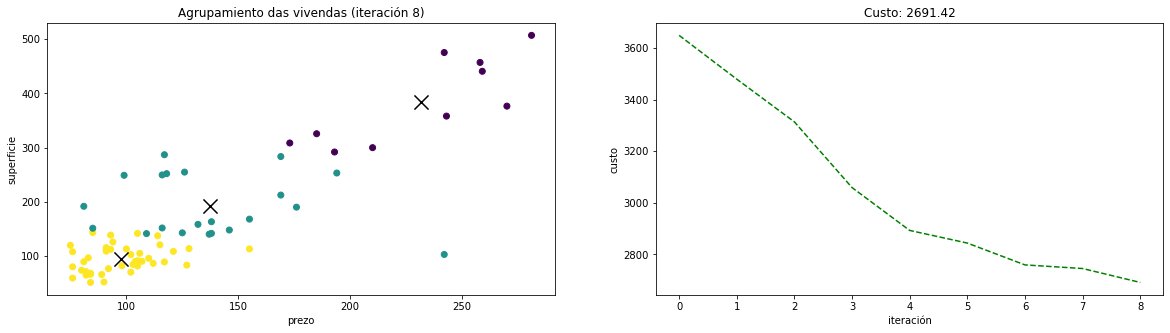

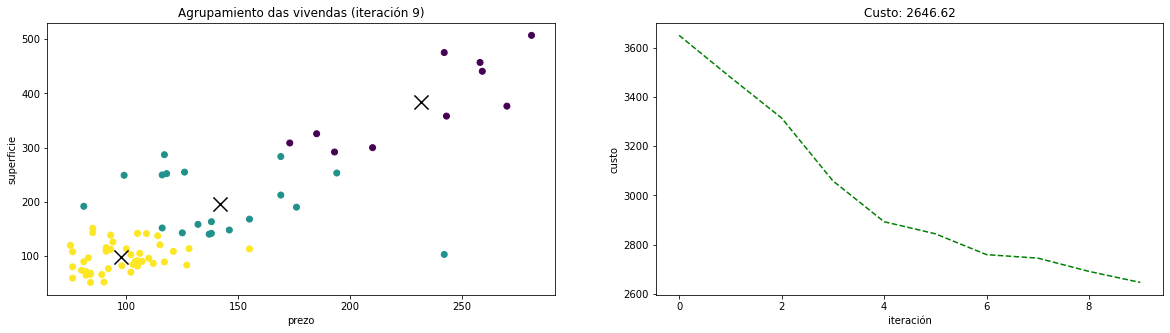

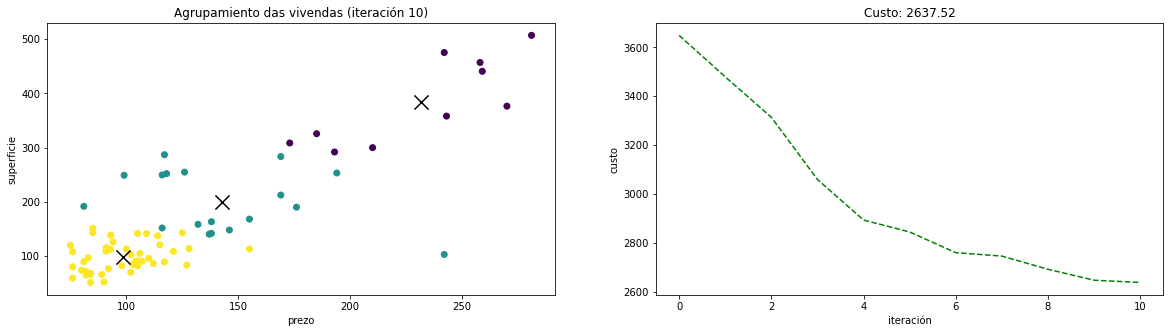

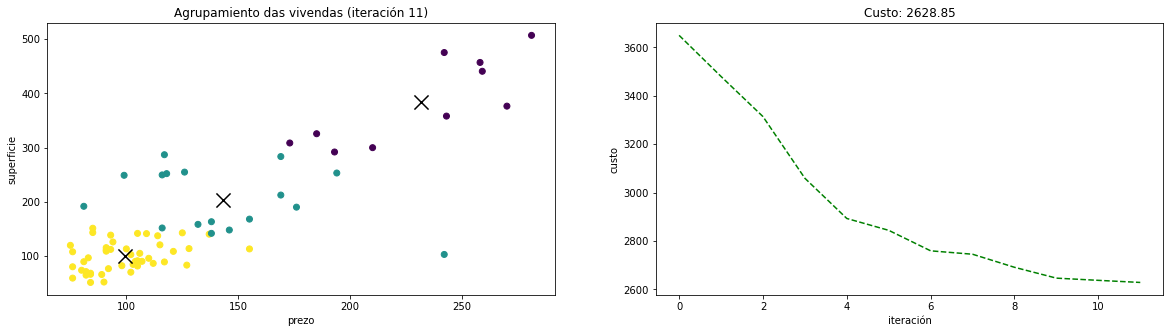

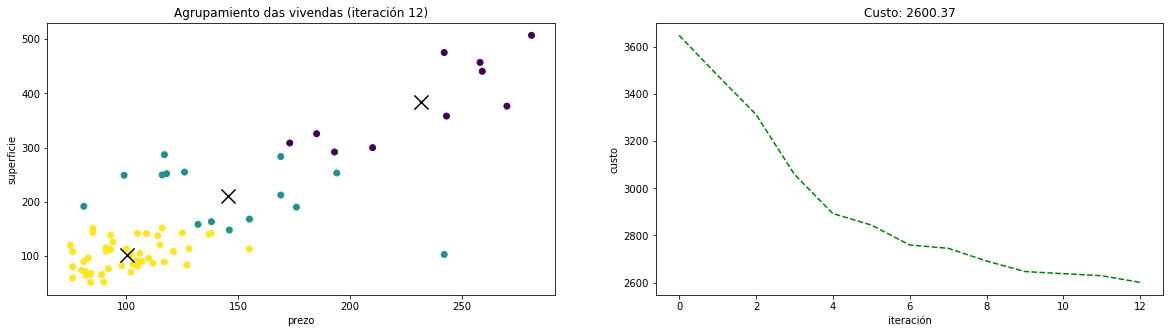

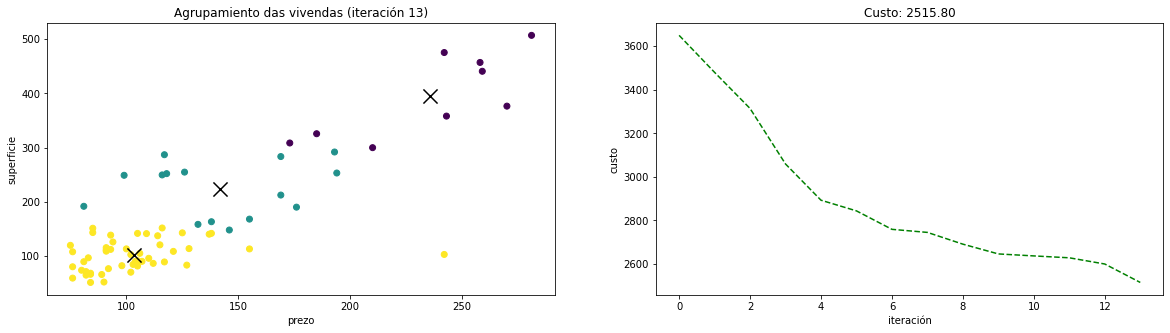

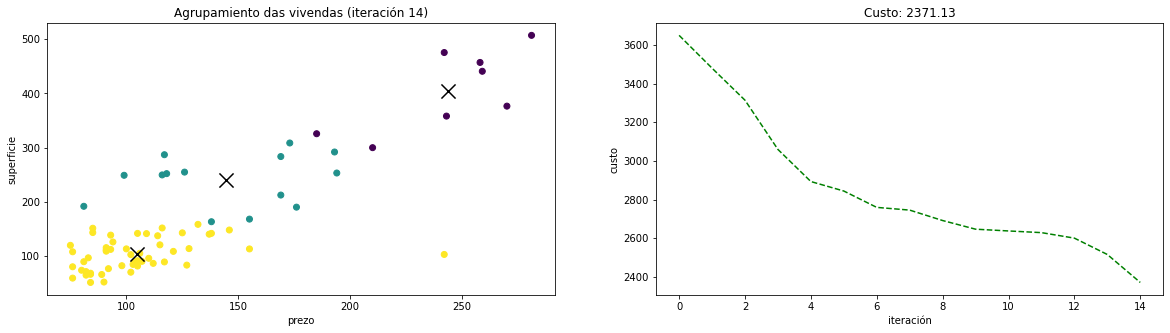

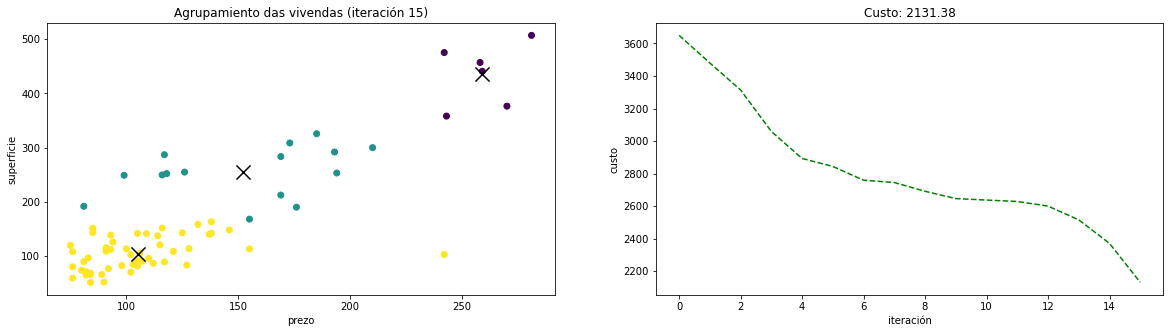

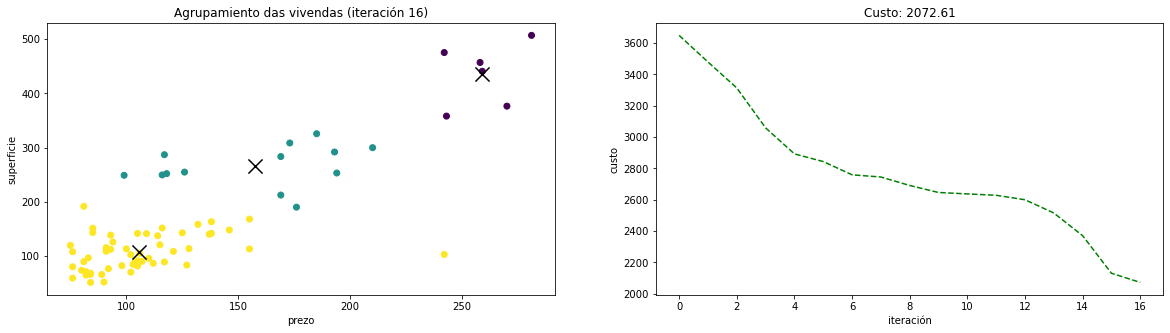

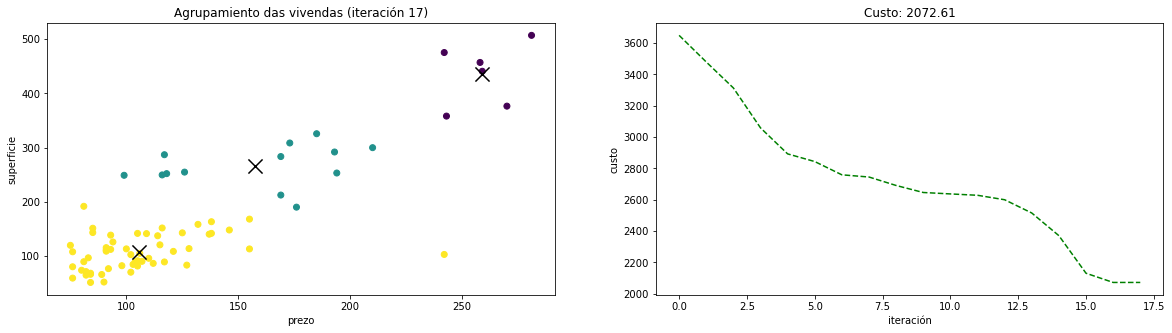

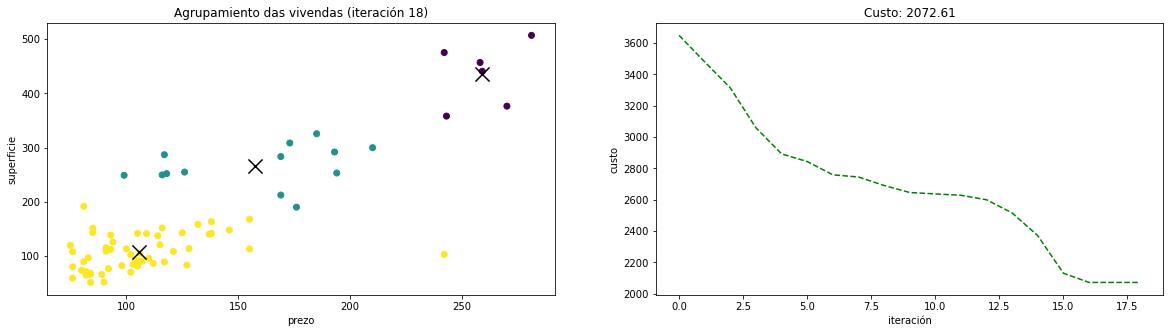

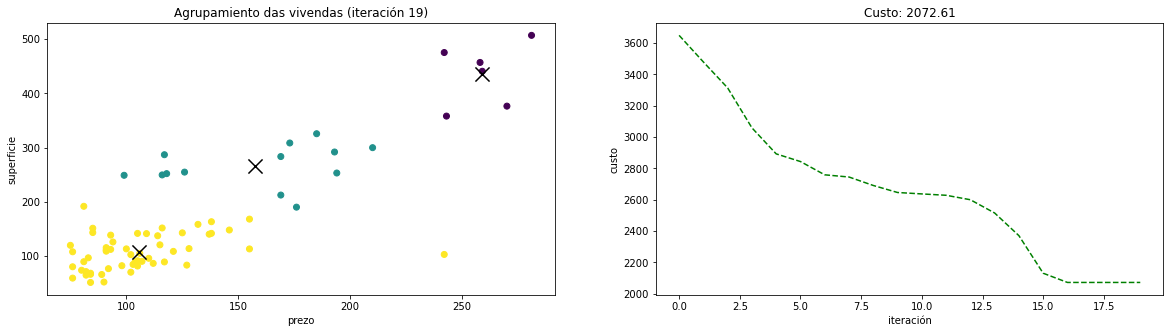

In [164]:
import matplotlib.pyplot as plt

for i in range(n_iter):
    fig = plt.figure(figsize=(20, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
    ax1 = fig.add_subplot(121, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo, queremos unha matrix [1,2])
    ax2 = fig.add_subplot(122, projection='rectilinear')
    
    # Engadimos os scatterplots
    ax1.scatter(vivendas['superficie'], vivendas['prezo'], c=agrupamento_1['clusters'][i])  #Vivendas
    ax1.scatter(agrupamento_1['centroides'][i][:, 0], agrupamento_1['centroides'][i][:, 1],
                s=200, marker='x', color='black')  # Centroides
    ax1.set_title("Agrupamiento das vivendas (iteración {})".format(i))  # Poñemos un título
    ax1.set_xlabel("prezo")  # Nombramos os eixos
    ax1.set_ylabel("superficie")
    
    # Engadimos os custos
    ax2.plot(range(i+1), agrupamento_1['custo'][:i+1], '--', color="green")
    ax2.set_title("Custo: {:.2f}".format(agrupamento_1['custo'][i]))  # Poñemos un título
    ax2.set_xlabel("iteración")  # Nombramos os eixos
    ax2.set_ylabel("custo")


    plt.show()  # Mostramos a figura por pantalla

Nas figuras anteriores, a gráfica da esquerda indica sempre o agrupamento realizado. Os exemplos do conxunto de datos coloréanse de distinta cor en función do cluster ao que son asignados. As **x** cunha circunferencia arredor ubican os centroides. Na gráfica da dereita temos a evolución do custo ($J$) nas sucesivas iteracións, tal e como faciamos en regresión lineal.

Agora que viches o proceso de clustering paso a paso, trata de responder ás seguintes cuestións.

> ❓ **_Pregunta 1._**  Lembra que na práctica anterior o custo viña dado polo erro cadrático medio das diferenzas entre cada predición e o valor do prezo real. Como estimamos o custo no caso da aprendizaxe non supervisada con k-means?

El coste en este caso consiste en la distancia entre cada punto a su centro



> ❓ **_Pregunta 2._**  Explica que é a saída da función `calcula_distancias`.

La función calcula distancia devuelve una matriz de distancias entre dos conjuntos de numeros. En el algoritmo k-means se utiliza para saber la distancia del conjunto x,lista de puntos, a los centroides, lista de puntos que son centros.


> ❓ **_Pregunta 3._**  Explica que contén `x_cluster_i` e que é o que fai a expresión `np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0]` na función `actualiza_centr`.

La variable x_cluster_i almacena todos aquellos puntos que tienen como centro asignado el centro i(se recorren todos los centroides/centros). La expresión np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0] realiza la suma de todos los puntos tanto en sus cordenadas x como sus cordenadas y, y finalmente utiliza eso para reajustar la posición de los centros.



> ❓ **_Pregunta 4._**  Identifica no código dos scripts anteriores onde se realizan cada unha das 3 etapas de k-means (inicialización, asignación dos datos aos clusters e actualización dos centroides).

La etapa de inicialización de las distancias de los puntos a los centroides, sucede en la primera línea de cada ejecución "dist_centroides = calcula_distancias(x, centroides)". La etapa de asignacion de los puntos a los clusters se ejecuta una vez se haya ejecutado la etapa de inicialización, en cocreto en la linea "clusters = np.argmin(dist_centroides, axis=1)" que toma la posición con el valor mínimo de las distancias a los centroides para cada punto(tomando así el índice para el centro, con distancia mínima, del vector centroides).La etapa de actualización de los centroides se produde posterior a las dos etapas anteriores, "centroides = actualiza_centr(x, clusters, centroides)", donde se actualiza la posición a la media de las distancias de todos sus centros asignados.


### Inicialización aleatoria múltiple dos centroides

Se cambiamos os centroides iniciais, o algoritmo pode non converxer aos mesmos resultados.

In [165]:
SEED_VALUE = 22634  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados

np.random.seed(SEED_VALUE)
centr_iniciais_2 = vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]
centr_iniciais_2

array([[259.  , 440.83],
       [ 81.  ,  89.52],
       [126.  , 254.81]])

In [166]:
# Realizamos un novo agrupamento
agrupamento_2 = k_medias(vivendas_mat, centr_iniciais_2, n_iter)

Neste caso, posto que o problema é pequeno e sinxelo, 20 iteracións son máis que suficientes para converxer ao agrupamento óptimo, sexan cales sexan os centroides de arranque:

In [167]:
# Centroides finais do primeiro agrupamento
agrupamento_1['centroides'][n_iter-1]

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

In [168]:
# Centroides finais do segundo agrupamento
agrupamento_2['centroides'][n_iter-1]

array([[258.83333333, 435.845     ],
       [105.77777778, 107.42740741],
       [157.30769231, 265.95846154]])

Fíxate que, aínda que en esencia os resultados son os mesmos que no primeiro agrupamento, os centroides 2 e 3 están intercambiados, polo que tecnicamente a solución á que chega o algoritmo é outra (e, porén, todo o proceso iterativo foi distinto).

En moitos problemas reais os resultados cambiarán moito en función de como inicialicemos os centroides. Incluso no problema das vivendas, se o número de iteracións é máis pequeno (por exemplo, 10), non sempre se acadará o óptimo global. Porén sóense realizar múltiples ($m$) inicializacións aleatorias dos centroides. A seguinte función é unha extensión da función base `k_medias` que permite executar o k-means para $m$ inicializacións distintas dos centroides e un valor $k$ constante:

In [169]:
# Función k-means de inicialización aleatoria múltipe
def k_medias_multi_ini(x, n, m, k):
    x_mat = x.values
    custos_finais = []
    centroides_finais = []
    clusters_finais = []
    for i in range(m):
        centr_iniciais = x_mat[np.random.choice(x_mat.shape[0], size=k, replace=False)]
        agrupamento = k_medias(x_mat, centr_iniciais, n)
        custos_finais.append(agrupamento['custo'][n-1])
        centroides_finais.append(agrupamento['centroides'][n-1])
        clusters_finais.append(agrupamento['clusters'][n-1])
    
    custo_minimo = min(custos_finais)
    indice_mellor = np.argmin(custos_finais)
    centroides_mellor = centroides_finais[indice_mellor]
    clusters_mellor = clusters_finais[indice_mellor]
    
    return {'custo_minimo': custo_minimo, 'mellor_iteracion': indice_mellor,
            'mellores_centroides': centroides_mellor, 'mellor_asignacion': clusters_mellor}

Imos probar a función anterior:

In [170]:
SEED_VALUE = 134  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)

m_ini = 10
n_iter = 15
k_cent = 3
agrupamento_3 = k_medias_multi_ini(x=vivendas, n=n_iter, m=m_ini, k=k_cent)

In [171]:
# Mellor iteración
agrupamento_3['mellor_iteracion']

5

In [172]:
# Mellores centroides
agrupamento_3['mellores_centroides']

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

In [173]:
# Asignación do mellor cluster para cada un dos 6 primeiros exemplos do dataset:
agrupamento_3['mellor_asignacion'][:6]

array([2, 1, 1, 2, 1, 2])

> ❓ **_Pregunta 5._**  Que devolve a saída da función `k_medias_multi_ini`? Como se elixen os mellores centroides?

Obtener diferentes estados iniciales en las posiciones de los centros, puede derivar en una mayor o menos distancia entre los centros y sus puntos asignados y por lo tanto en un menor error. Así devuelve cual ha sido la mejor inicialización de todas las que ha probado, el coste mínimo, mejores centros y la mejor asignación de puntos a sus centros.


### Selección do número de centroides

Polo de agora mantivemos o valor de $k$ constante, facendo sempre agrupamentos en 3 clusters. Unha pregunta que che podería xurdir a estas alturas é como saber cal é o número de centroides máis axeitado. A selección do $k$ óptimo é a miúdo ambigua, con interpretacións que dependen da forma e a escala da distribución de puntos no conxunto de datos. Aumentar o $k$ sen penalización sempre reducirá o valor do custo na agrupación resultante, ata o caso extremo de custo cero se cada punto dos datos se considera como o seu propio agrupamento (é decir, cando $k$ é igual ao número de exemplos do conxunto de datos). Intuitivamente, a elección óptima de $k$ acadará un equilibrio entre a compresión máxima dos datos utilizando un só cluster e a máxima precisión ao asignar cada instancia ao seu cluster propio. 

Cando o valor apropiado de $k$ non é evidente a partir do coñecemento previo das propiedades do conxunto de datos, existen métodos que nos axudan a tomar esta decisión. Un dos máis sinxelos é o **método do cóbado** (en inglés, *elbow method*), o cal analiza a redución do custo en función do número de clusters: debe elixirse aquel número de clusters tal que, ao agregar outro cluster máis non se acaden resultados moito mellores. Dun xeito máis formal, se se grafica o custo obtido en función de $k$, os primeiros agrupamentos terán un alto erro por agrupar moitos datos en poucos clusters, pero nalgún momento a ganancia marxinal caerá, provocando un "cóbado" no gráfico. O número de clusters fíxase a este punto, de ahí o nome do método. 

O seguinte script executa o método `k_medias_multi_ini` para distintos valores de $k$ (o mínimo é $k=2$):

In [174]:
SEED_VALUE = 42  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)

k_max = 10
m_ini = 10
n_iter = 20
custos_finais = []
centroides_finais = []
clusters_finais = []
for k in range(2, k_max+1):
    agrupamento = k_medias_multi_ini(x=vivendas, n=n_iter, m=m_ini, k=k)
    custos_finais.append(agrupamento['custo_minimo'])
    centroides_finais.append(agrupamento['mellores_centroides'])
    clusters_finais.append(agrupamento['mellor_asignacion'])

> ❓ **_Pregunta 6._**  Cantas veces se executa o algoritmo k-means no script anterior?

El scritp anterior se ejecuta en función a la variable establecida k_max, entonces si comenzamos en 2 y vamos hasta k_max+1 --> se ejecuta k_max-1 veces, en este caso por lo tanto son 9 veces.

Agora imos aplicar o método do cóbado para determinar o número óptimo de clusters. Para iso, graficamos a evolución do custo en función de $k$:

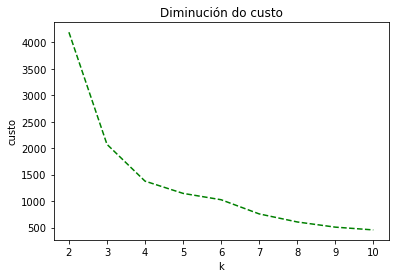

In [175]:
plt.plot(range(2, k_max+1), custos_finais, '--', color="green")
plt.title("Diminución do custo") 
plt.xlabel("k")
plt.ylabel("custo")
plt.show()

A simple vista pódese apreciar que o "cóbado" da función está en $k=4$. A partir deste valor a mellora que obtemos é moito menos significativa. Por tanto podemos asumir que o número de clusters ideal é 4:

In [176]:
k_mellor = 4

# Centroides para o mellor k (4)
centroides_mellor = centroides_finais[k_mellor-2]  # Hai que ter en conta que a lista comeza en 2
centroides_mellor

array([[128.75      , 145.0095    ],
       [ 94.65714286,  88.31571429],
       [155.75      , 272.275     ],
       [258.83333333, 435.845     ]])

In [177]:
# Asignación do mellor cluster para cada un dos 6 primeiros exemplos do dataset
clusters_mellor = clusters_finais[k_mellor-2]  # Hai que ter en conta que a lista comeza en 2
clusters_mellor[:6]

array([0, 2, 2, 0, 2, 1])

Graficamos o último agrupamento, que imos considerar o definitivo:

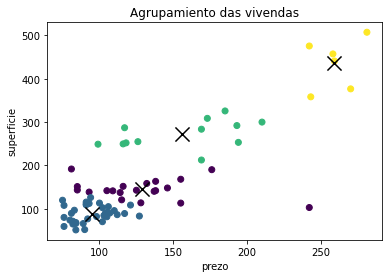

In [178]:
fig = plt.figure()  # Creamos unha figura (contenedor para elementos a debuxar)
ax1 = fig.add_subplot(111, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo)

# Engadimos os scatterplots
ax1.scatter(vivendas['superficie'], vivendas['prezo'], c=clusters_mellor)  #Vivendas
ax1.scatter(centroides_mellor[:, 0], centroides_mellor[:, 1], s=200, marker='x', color='black')  # Centroides

ax1.set_title("Agrupamiento das vivendas")  # Poñemos un título
ax1.set_xlabel("prezo")  # Nombramos os eixos
ax1.set_ylabel("superficie")

plt.show()  # Mostramos a figura por pantalla

### Interpretación dos resultados

Quedaría agora unha última etapa de análise e interpretación dos resultados. Haberá situacións (coma esta) onde a interpretación sexa bastante trivial. Sen embargo, en moitos problemas reais onde se traballa cun maior número de variables (porén, xa non estamos falando de interpretar un simple gráfico 2D) pode resultar moi complexo lograr atribuírlle un significado aos grupos formados.

> ❓ **_Pregunta 7._**  Fai unha breve interpretación dos clusters obtidos.

Esta interpretación es bastante sencilla. Hemos distribuido los punto en 4 conjuntos(4 centros) desiguales y de diferente tamaño. Los puntos con una menor superficie y un menor precio son más abundantes que los que tienen mayor superficie y en consecuencia mayor precio. Un detalle importante es que el punto atípico que tenemos también pertenece a un conjunto.

## Agrupamento coa función `KMeans`

Unha vez máis, `scikit-learn` facilítanos as tarefas de clustering proporcionándonos paquetes e funcións moi útiles. Unha das funcións imprescindibles é `KMeans`. No seguinte script imos volver a obter o primeiro dos agrupamentos que realizamos no exercicio anterior, pero invocando a `KMeans` en lugar de `k_medias`:

In [179]:
from sklearn.cluster import KMeans

# Definimos o número de iteracións
n_iter <- 20

# Obtemos os mesmos centroides iniciais que antes
SEED_VALUE = 190463  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)
centr_iniciais = vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]

# Definimos o modelo
model = KMeans(n_clusters=len(centr_iniciais), init=centr_iniciais, n_init=1,
               max_iter=n_iter, algorithm='full', random_state=SEED_VALUE)

# Axustamos o modelo aos datos
np.random.seed(SEED_VALUE)
agrupamento_4 = model.fit(vivendas)

O argumento `algorithm="full"` simplemente nos asegura que por debaixo estamos empregando o mesmo método que o que implementamos no exercicio anterior (hai varias implementacións, podes consultalas na axuda de `scikit-learn`). Vemos que os centroides que obtemos con `KMeans` son os mesmos que obtiñamos antes coa nosa implementación propia:

In [180]:
# Centroides da implementación propia
agrupamento_1['centroides'][-1]

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

In [181]:
# Centroides obtidos coa función KMeans
agrupamento_4.cluster_centers_

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

Bótalle un ollo aos atributos que contén a clase `KMeans`. Observa que entre todos os datos de saída non se inclúe directamente o custo da función $J$ coa que estivemos traballando. Inclúese a suma de todas as distancias, sen facer a media:

In [182]:
# Custo final coa implementación propia
agrupamento_1['custo'][-1]

2072.6093651192277

In [183]:
# Custo final coa función KMeans
agrupamento_4.inertia_ / len(vivendas)

2072.6093651192286

Tamén podemos facer o cálculo manualmente, usando a función $J$ que temos definida:

In [184]:
j(x=vivendas_mat, centroides=agrupamento_4.cluster_centers_, clusters=agrupamento_4.labels_)

2072.6093651192286

**************************************************************

# Respostas ao cuestionario (4 puntos)

**LEMBRA:** Non esquezas de escribir teu nome e apelidos na segunda celda do presente documento.

❓ **_Pregunta 1._  Lembra que na práctica anterior o custo viña dado polo erro cadrático medio das diferenzas entre cada predición e o valor do prezo real. Como estimamos o custo no caso da aprendizaxe non supervisada con k-means?**

El coste en este caso consiste en la distancia entre cada punto a su centro

❓ **_Pregunta 2._ Explica que é a saída da función `calcula_distancias`.**

La función calcula distancia devuelve una matriz de distancias entre dos conjuntos de numeros. En el algoritmo k-means se utiliza para saber la distancia del conjunto x,lista de puntos, a los centroides, lista de puntos que son centros.



❓ **_Pregunta 3._  Explica que contén `x_cluster_i` e que é o que fai a expresión `np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0]` na función `actualiza_centro`.**

La variable x_cluster_i almacena todos aquellos puntos que tienen como centro asignado el centro i(se recorren todos los centroides/centros). La expresión np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0] realiza la suma de todos los puntos tanto en sus cordenadas x como sus cordenadas y, y finalmente utiliza eso para reajustar la posición de los centros.



❓ **_Pregunta 4._  Identifica no código dos scripts anteriores onde se realizan cada unha das 3 etapas de k-means (inicialización, aignación dos datos aos clusters e actualización dos centroides).**

La etapa de inicialización de las distancias de los puntos a los centroides, sucede en la primera línea de cada ejecución "dist_centroides = calcula_distancias(x, centroides)". La etapa de asignacion de los puntos a los clusters se ejecuta una vez se haya ejecutado la etapa de inicialización, en cocreto en la linea "clusters = np.argmin(dist_centroides, axis=1)" que toma la posición con el valor mínimo de las distancias a los centroides para cada punto(tomando así el índice para el centro, con distancia mínima, del vector centroides).La etapa de actualización de los centroides se produde posterior a las dos etapas anteriores, "centroides = actualiza_centr(x, clusters, centroides)", donde se actualiza la posición a la media de las distancias de todos sus centros asignados.



❓ **_Pregunta 5._ Que devolve a saída da función `k_medias_multi_ini`? Como se elixen os mellores centroides?**

Obtener diferentes estados iniciales en las posiciones de los centros, puede derivar en una mayor o menos distancia entre los centros y sus puntos asignados y por lo tanto en un menor error. Así devuelve cual ha sido la mejor inicialización de todas las que ha probado, el coste mínimo, mejores centros y la mejor asignación de puntos a sus centros.



❓ **_Pregunta 6._  Cantas veces se executa o algoritmo k-means no script anterior?**

El scritp anterior se ejecuta en función a la variable establecida k_max, entonces si comenzamos en 2 y vamos hasta k_max+1 --> se ejecuta k_max-1 veces, en este caso por lo tanto son 9 veces.




❓ **_Pregunta 7._ Fai unha breve interpretación dos clusters obtidos.**

Esta interpretación es bastante sencilla. Hemos distribuido los punto en 4 conjuntos(4 centros) desiguales y de diferente tamaño. Los puntos con una menor superficie y un menor precio son más abundantes que los que tienen mayor superficie y en consecuencia mayor precio. Un detalle importante es que el punto atípico que tenemos también pertenece a un conjunto.



**************************************************************

# Modelado dun problema de libre elección 

## Enunciado

Pon en práctica os teus coñecementos de aprendizaxe non supervisado e intenta agora ti buscar relacións entre os datos dun problema que se che ocorra. Nos exercicios anteriores abordouse o caso de 2 variables, polo que animámoste agora a que trates de aplicar clustering sobre un problema con máis dimensións. O único requerimento obrigatorio é **empregar máis de dúas variables para o clustering**. Ten en conta que a nosa implementación de k-means (`k_medias`) está pensada para funcionar sobre conxuntos de datos con dúas variables, pero non é escalable a máis dimensións (certo é que as modificacións necesarias para logralo son mínimas). A vantaxe da función `KMeans` propia de `scikit-learn` é a súa flexibilidade, pois o seu parámetro `x` pode tomar como entrada conxuntos de datos cun maior número de variables. Ten tamén presente que ao aplicar clustering sobre un conxunto de datos de máis de 2 ou 3 variables, a súa visualización complícase e o mellor é visualizar o agrupamento por pares de variables de cara a obter unha boa interpretación.

Igual que na práctica anterior, podes recadar datos e construir un pequeno dataset ti mesmo ou ben obter un de Internet. Fai un breve estudo dos teus datos, incluíndo gráficas e comentarios propios. Obtén un bo agrupamento e da unha interpretación do mesmo. Proporciona todo o código que consideres necesario empregando scripts como os dos exercicios anteriores. Ao entregar esta práctica deberás incluir tamén o arquivo cos datos do teu problema no formato que che resulte máis cómodo (.csv, .txt, etc.).

**************************************************************

## Resposta (6 puntos)

Para la implementación del método de K-means, se ha tomado un dataset de la web: https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html. Este dataset representa la tasa de cirrosis en base a varias variables predictoras. Para este problema se ha obtado por tomar únicamente dos variables predictoras y la variable de estudio. Las variables predicotoras seán: consumo de licor per capita y consumo de vino per capita. Con esas dos obtenemos la tasa de mortalidad por cirrosis.

En un primer momento realizaremos una carga de datos y comprensión de los mismo con la finalidad de enteder la relación, correlación, entre las variables y entender el problema para comprender los resultados obtenidos y justificar si estos son correctos o nos hemos equivocado en alguna parte del proceso, tener capacidad crítica.

Una vez tenemos los datos realizaremos clustering utilizando el método de K-Means implementado manualmente, el método k-means importado a través de la librería sklearn.cluster y por último comprobaremos la asignación múltiple aleatoria para justificar la asignación de centros.

NOTA: En caso de utilizar más variables predictoras, cambiar el algoritmo no resulta difícil. Lo realmente complicado es obetener un gŕafico en N dimensiones que sea interesante y aporte información.

## Carga de datos e comprensión dos mesmos

In [185]:
import pandas as pd  # Importamos a librería (isto sólo é necesario facelo unha vez)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt  # Importamos a libraría (isto sólo é necesario facelo unha vez)
import numpy as np  # Importamos NumPy, para operacións matemáticas

mortalidad_cirrosis = pd.read_csv('mortalidad_cirrosis.csv',delimiter=' ',header=0)

In [186]:
mortalidad_cirrosis.head(n=mortalidad_cirrosis.shape[0])

,vino_per_capita,licor_per_capita,tasa_mortalidad_cirrosis
0,5,30,41.2
1,4,41,31.7
2,3,38,39.4
3,7,48,57.5
4,11,53,74.8
5,9,65,59.8
6,6,73,54.3
7,3,32,47.9
8,12,56,77.2
9,7,57,56.6



### Representación 3D de las tres variables
> **#x vino_per_capita, v.predictora**

> **#y licor_per_capita, v.predictora**

> **#z tasa_mortalidad_cirrosis**

<IPython.core.display.Javascript object>


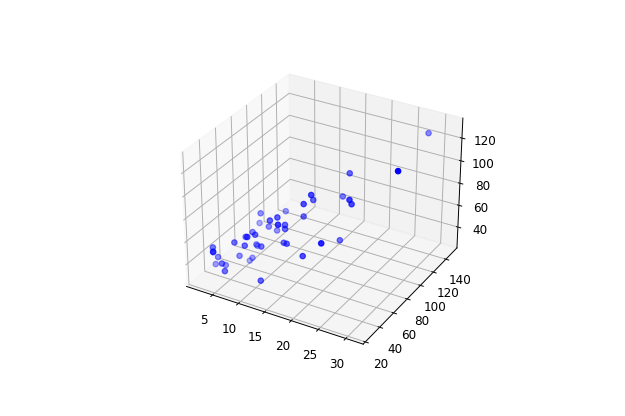

In [187]:
%matplotlib notebook
#Crear la figura
fig = plt.figure() 
#Crear el plano 3D
ax = fig.add_subplot(111,projection='3d') 
#Datos:
#x vino_per_capita, v.predictora
#y licor_per_capita, v.predictora
#z tasa_mortalidad_cirrosis
x = mortalidad_cirrosis["vino_per_capita"]
y = mortalidad_cirrosis["licor_per_capita"]
z= mortalidad_cirrosis["tasa_mortalidad_cirrosis"]
#Añadir al plano los datos
ax.scatter3D(x,y,z,c='b',marker='o')
plt.show()

In [188]:
%matplotlib inline

En las representaciones 3D resulta más complicado observar las relaciones entre las variables, por lo tanto la mejor solución es realizar representaciones 2D por pares. Tomando como una de las variables de los pares la variable **tasa_mortalidad_cirrosis**.

<AxesSubplot:xlabel='vino_per_capita', ylabel='tasa_mortalidad_cirrosis'>

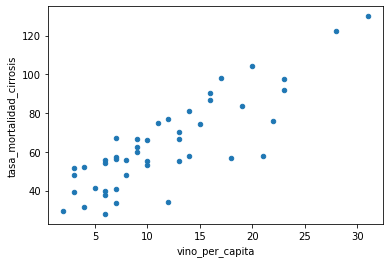

In [189]:
mortalidad_cirrosis.plot(kind='scatter', x = 'vino_per_capita', y = 'tasa_mortalidad_cirrosis')

<AxesSubplot:xlabel='licor_per_capita', ylabel='tasa_mortalidad_cirrosis'>

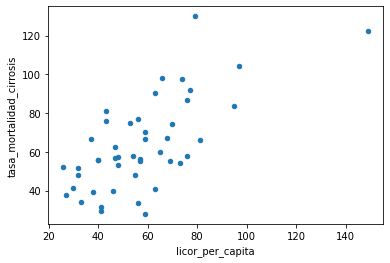

In [190]:
mortalidad_cirrosis.plot(kind='scatter', x = 'licor_per_capita', y = 'tasa_mortalidad_cirrosis')

<IPython.core.display.Javascript object>


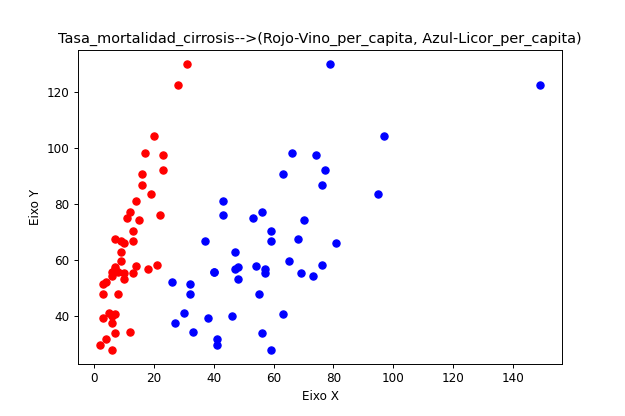

In [191]:
#Si queremos juntar ambos datos obtenidos en un único gráfico 2D, tenemos:

# Indicámoslle ao Notebook que queremos figuras interactivas
%matplotlib notebook

#Datos
x1 = mortalidad_cirrosis["vino_per_capita"]
x2 = mortalidad_cirrosis["licor_per_capita"]
y = mortalidad_cirrosis["tasa_mortalidad_cirrosis"]

# Debuxamos os datos
fig = plt.figure()  # Creamos unha figura (contenedor para elementos a debuxar)
ax = fig.add_subplot(111, projection='rectilinear')  # Engadimos un Axes á figura (contén os elementos do debuxo)

ax.scatter(x1, y, color="red")  # Engadimos un scatterplot vermello
ax.scatter(x2, y, color="blue")  # Engadimos un scatterplot azul

ax.set_title("Tasa_mortalidad_cirrosis-->(Rojo-Vino_per_capita, Azul-Licor_per_capita)")  # Poñemos un título

plt.xlabel("Eixo X")  # Nombramos os eixos
plt.ylabel("Eixo Y")

plt.show()  # Mostramos a figura por pantalla


In [192]:
%matplotlib inline

In [193]:
mortalidad_cirrosis.corr()

,vino_per_capita,licor_per_capita,tasa_mortalidad_cirrosis
vino_per_capita,1.000000,0.675921,0.844611
licor_per_capita,0.675921,1.000000,0.681969
tasa_mortalidad_cirrosis,0.844611,0.681969,1.000000


Con las diferentes representaciones y la función object.corr() hay datos suficientes para comprobar que ambas variables son directamente dependientes con respecto a **tasa_mortalidad_cirrosis**, es decir si aumenta la variable vino_per_capita aumenta tasa_mortalidad_cirrosis y si aumenta licor_per_capita también aumenta mortalidad_cirrosis.corr(). Lo mismo sucede al disminuir. La gran diferencia entre las dos variables es que vino_per_capita tiene una mayor correlación con tasa_mortalidad_cirrosis. 

De forma más clara pododemos verlo en el gráfico anterior donde tenemos ambas variables comparadas con la variable tasa_mortalidad_cirrosis. Así vemos a la variable vino_per_capita con mayor concentración y a la variable licor_per_capita más dispersa. Seguramente con regresión linea podríamos haber generado un modelo predictor muy bueno.

## Clustering sobre tasa de mortalidad por cirrosis con K-means adaptado

In [194]:
# Función de distancia cadrática
def calcula_distancias(a, b): #Distancia entre un conjunto de puntos y un centroide
    matriz_distancias = np.empty([a.shape[0], b.shape[0]])
    # Calculamos a distancia punto a punto dos conxuntos a e b
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            dist = a[i] - b[j]
            matriz_distancias[i, j] = dist[0] ** 2 + dist[1] ** 2 + dist[2] ** 2
    
    return matriz_distancias

# Función a optimizar J
def j(x, centroides, clusters):
    # Obtemos a distancia de cada punto ao seu cluster
    distancias = x - centroides[clusters]
    # Calculamos o custo formula dispositiva 7 del temario
    custo = 1.0/x.shape[0] * sum((np.sqrt(distancias[:, 0]**2 + distancias[:,1]**2 + distancias[:,2]**2))**2)
    return custo

# Función de actualización de centroides
def actualiza_centr(x, clusters, centroides):
    for i in range(centroides.shape[0]):
        #Todos los puntos que pertecen al cluster/centro
        """
        for j in range(x):
            if cluster[j] == i:
                x_cluster.append(x[j])
        """
        x_cluster_i = x[clusters==i]
        #Mover el centro segun el punto medio de todos los puntos que pertenecen al centroide
        centroides[i] = np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0] 
    return centroides

# Función de clustering k-means
def k_medias(x, centroides, iteracions):
    hist_clusters = []
    hist_centroides = []
    hist_custo = []
    for i in range(iteracions):
        distancia_centroides = calcula_distancias(x, centroides)
                
        clusters = np.argmin(distancia_centroides, axis=1)#Devuelve la posicion donde esta la distancia mínima
        
        centroides = actualiza_centr(x, clusters, centroides)
        
        custo = j(x, centroides, clusters)
        
        # Gardamos o historial de cada iteración
        hist_clusters.append(clusters)
        hist_centroides.append(centroides.copy())
        hist_custo.append(custo)
        
    
    return {'custo': hist_custo, 'clusters': hist_clusters, 'centroides': hist_centroides}

In [195]:
SEED_VALUE = 190463  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados

mortalidad_cirrosis_mat = mortalidad_cirrosis.values

np.random.seed(SEED_VALUE)
centr_iniciais = mortalidad_cirrosis_mat[np.random.choice(mortalidad_cirrosis_mat.shape[0], size=3, replace=False)]
centr_iniciais

# Definimos o número de iteracións do algoritmo
n_iter = 20
# Invocamos o método k_medias
agrupamento_1 = k_medias(mortalidad_cirrosis_mat, centr_iniciais, n_iter)

In [196]:
# Custo trala primeira iteración
agrupamento_1['custo'][0]

614.0527339975845

In [197]:
# Custo final
agrupamento_1['custo'][n_iter-1]

343.68936999147485

In [198]:
# Centroides na iteración 4
agrupamento_1['centroides'][3]

array([[ 21.44444444,  86.22222222, 100.58888889],
       [ 12.        ,  58.1       ,  64.73      ],
       [  5.88235294,  41.58823529,  42.4       ]])

In [199]:
# Asignación dos 6 primeiros exemplos do dataset aos clusters na última iteración
agrupamento_1['clusters'][n_iter-1][:6]

array([2, 2, 2, 1, 1, 1])

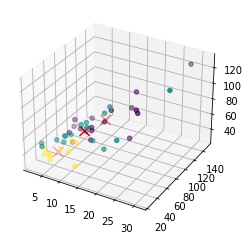

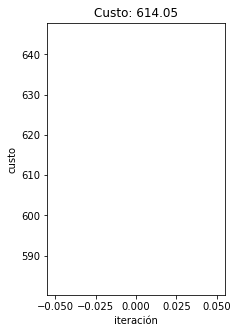

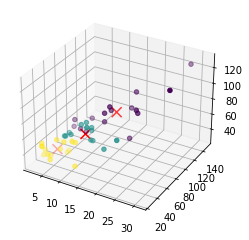

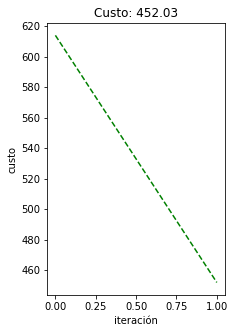

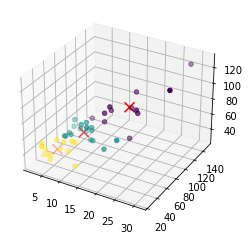

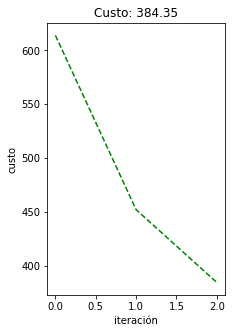

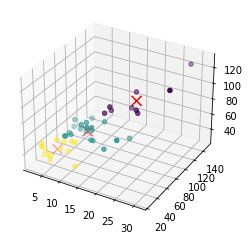

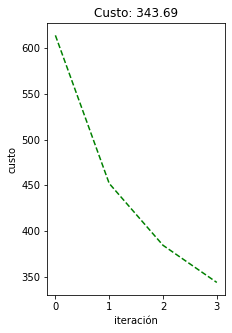

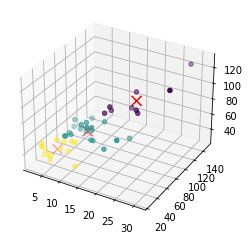

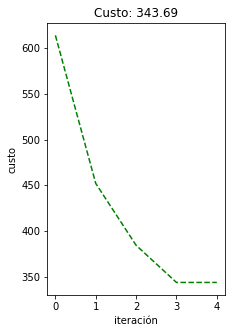

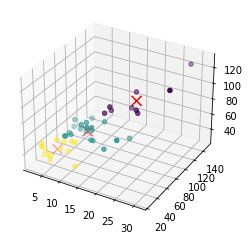

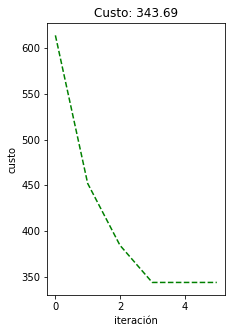

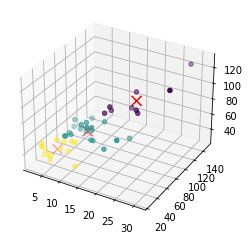

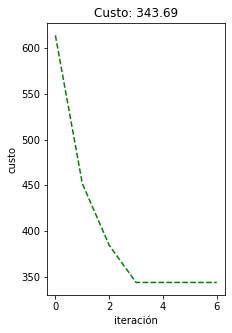

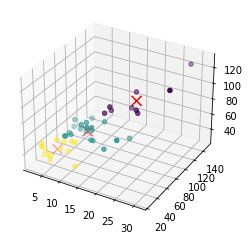

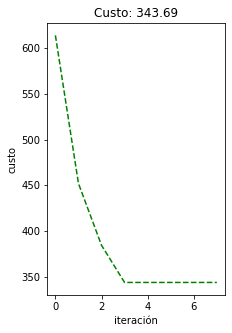

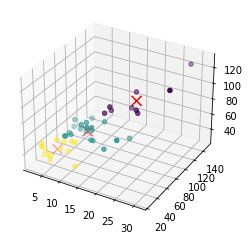

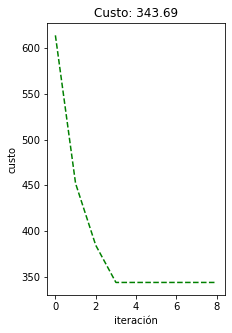

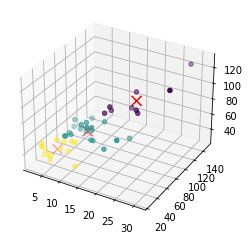

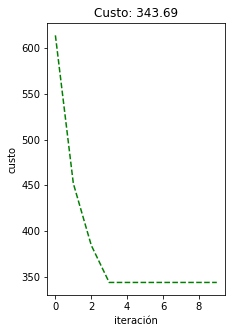

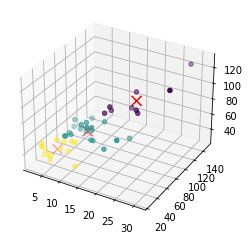

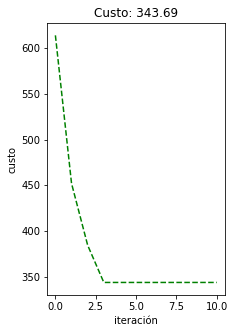

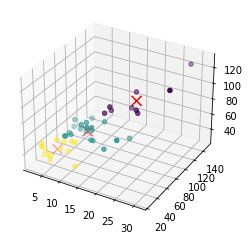

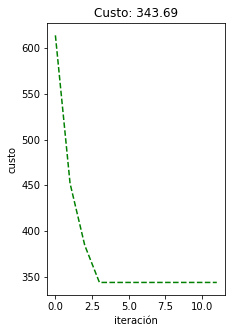

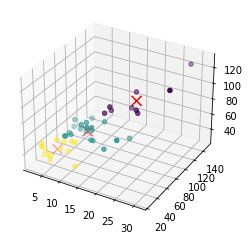

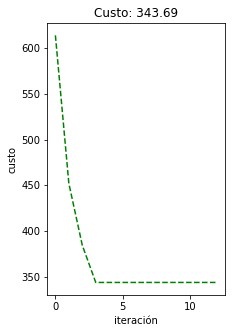

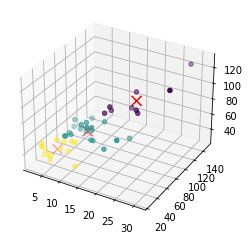

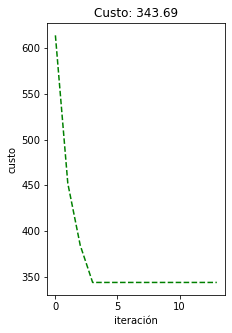

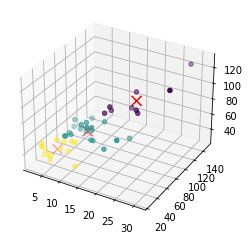

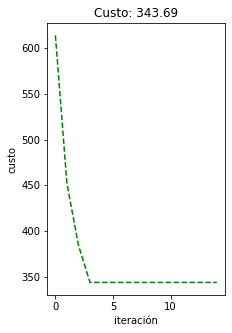

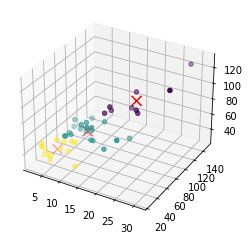

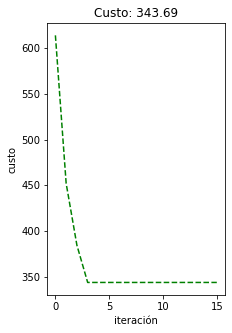

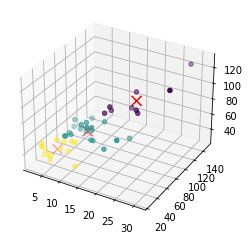

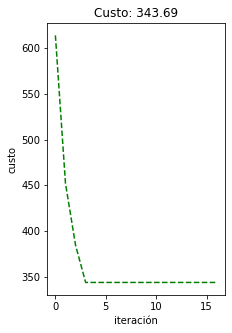

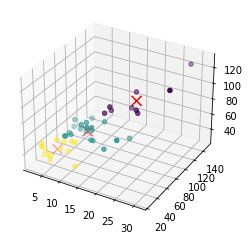

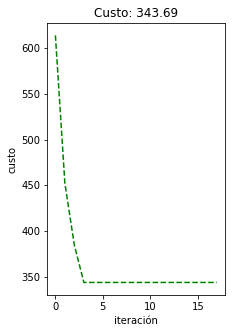

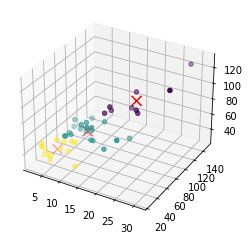

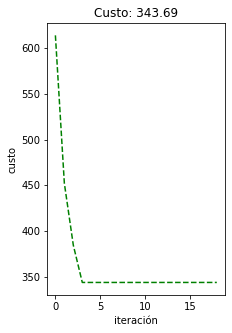

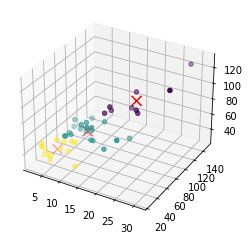

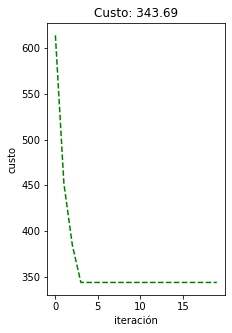

In [200]:
%matplotlib inline
for i in range(n_iter):
    ax = plt.axes(projection='3d')
    # Data for three-dimensional scattered points
    x = mortalidad_cirrosis["vino_per_capita"]
    y = mortalidad_cirrosis["licor_per_capita"]
    z= mortalidad_cirrosis["tasa_mortalidad_cirrosis"]
    ax.scatter3D(x, y, z, c=agrupamento_1['clusters'][i]);
    ax.scatter3D(agrupamento_1['centroides'][i][:, 0], agrupamento_1['centroides'][i][:, 1],agrupamento_1['centroides'][i][:, 2],
                 c='r',marker='x',s=100 ,cmap='Greens_r')
    
    # Engadimos os custos
    fig = plt.figure(figsize=(7, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
    ax2 = fig.add_subplot(122, projection='rectilinear')
    ax2.plot(range(i+1), agrupamento_1['custo'][:i+1], '--', color="green")
    ax2.set_title("Custo: {:.2f}".format(agrupamento_1['custo'][i]))  # Poñemos un título
    ax2.set_xlabel("iteración")  # Nombramos os eixos
    ax2.set_ylabel("custo")

    plt.show()  # Mostramos a figura por pantalla

La adaptación del algortimo k-means fue bastante sencilla, simplemente se debe tener en cuenta que los puntos tienen las mismas cordenadas que variables o dimensiones tiene nuestro dataset. En esta prueba he tomado únicamente tres variables. 

Grandes detalles a tener en cuenta es como varía la **función de coste utilizando K=3 desde la primera iteracción hasta llegar a la última(614.05 vs 343.68)**. Además durante la representación de los gráficos he conseguido implementar un gráfico del problema en 3D y una función de coste por iteracción lo que nos ayuda a entender el proceso. En este proceso podemos ver como los centros se actualizán y se mueven, podemos ver como se reasignan los puntos a los centros y como finalmente se equilibra bastante rápido la función de coste.

## Clustering sobre tasa de mortalidad por cirrosis con sklearn.cluster (KMeans)

In [201]:
from sklearn.cluster import KMeans

# Definimos o número de iteracións
n_iter <- 20

# Obtemos os mesmos centroides iniciais que antes
SEED_VALUE = 190463  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)

mortalidad_cirrosis_mat = mortalidad_cirrosis.values

centr_iniciais = mortalidad_cirrosis_mat[np.random.choice(mortalidad_cirrosis_mat.shape[0], size=3, replace=False)]

# Definimos o modelo
model = KMeans(n_clusters=len(centr_iniciais), init=centr_iniciais, n_init=1,
               max_iter=n_iter, algorithm='full', random_state=SEED_VALUE)

# Axustamos o modelo aos datos
np.random.seed(SEED_VALUE)
agrupamento_4 = model.fit(mortalidad_cirrosis)

In [202]:
# Custo final coa función KMeans de sklearn
agrupamento_4.inertia_ / len(mortalidad_cirrosis)

343.6893699914748

In [203]:
# Centroides obtidos coa función KMeans
agrupamento_4.cluster_centers_

array([[ 21.44444444,  86.22222222, 100.58888889],
       [ 12.        ,  58.1       ,  64.73      ],
       [  5.88235294,  41.58823529,  42.4       ]])

In [204]:
# Custo final coa función KMeans de sklearn == # Custo final implemtación K-Means
agrupamento_4.inertia_ / len(mortalidad_cirrosis)- agrupamento_1['custo'][n_iter-1]

-5.684341886080802e-14

La utilización de la librería sklearn.cluster, en concreto la función KMeans simplifica, aún más, la implementación del clustering para datsets con N dimensiones. Además, para K=3 nos devuelve el mismo coste, o muy cercano, que la implementación anteriormente vista. **La diferencia entre ambas implementaciones en la función de coste es -5.6843412e-14 que es del mismo orden aproximadamente que el epsilon de la máquina (2.22045E-16)**.

## Clustering sobre tasa de mortalidad por cirrosis con centros de inicialización aleatoria y K-Means adaptado

En muchos problemas difrentes la inicialización de los centros influye totalmente en el resultado y coste obtenido. Esto sucede cuando, por ejemplo, escogemos K centros muy desajustados y que necesitan de muchas iteracciones para converger y llegar a una solucón óptima. Incluso en ocasiones necesitan de más iteracciones de las asignadas ya que seguramente necesitan actualizar numerosas veces las posiciones de los centros. Con la implenetación anterior podemos realizar **m incializaciones con K centros y n iteracciones**.

Además existe otro problema y es el número de centros que debemos tener, cuanto más aumentemos el valor de k menor será el coste, hasta llegar a que el número de centros K sea igual al número de puntos del dataset y tener así un centro por punto y un coste de 0. Esta situación obviamente no nos interesa en clustering, por lo tanto podemos utilizar el método del codo y así ajustar el número de clusters o centros al punto del codo. 

En nuestra gráfica **Clustering sobre tasa de mortalidad por cirrosis con K-means adaptado** vemos que el codo existe para **K=2**. De esta manera podríamos optar a dos grupos: los que tienden a tener una alta tasa de mortalidad y baja tasa de mortallidad, ambas por cirrosis.

In [205]:
# Función k-means de inicialización aleatoria múltipe
def k_medias_multi_ini(x, n, m, k):
    x_mat = x.values
    custos_finais = []
    centroides_finais = []
    clusters_finais = []
    for i in range(m):
        centr_iniciais = x_mat[np.random.choice(x_mat.shape[0], size=k, replace=False)]
        agrupamento = k_medias(x_mat, centr_iniciais, n)
        custos_finais.append(agrupamento['custo'][n-1])
        centroides_finais.append(agrupamento['centroides'][n-1])
        clusters_finais.append(agrupamento['clusters'][n-1])
    
    custo_minimo = min(custos_finais)
    indice_mellor = np.argmin(custos_finais)
    centroides_mellor = centroides_finais[indice_mellor]
    clusters_mellor = clusters_finais[indice_mellor]
    
    return {'custo_minimo': custo_minimo, 'mellor_iteracion': indice_mellor,
            'mellores_centroides': centroides_mellor, 'mellor_asignacion': clusters_mellor}

In [206]:
SEED_VALUE = 134  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)

m_ini = 10
n_iter = 15
k_cent = 2
agrupamento_3 = k_medias_multi_ini(x=mortalidad_cirrosis, n=n_iter, m=m_ini, k=k_cent)

<IPython.core.display.Javascript object>


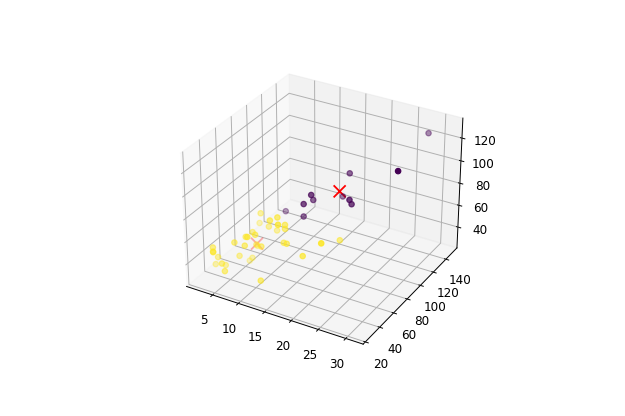

In [212]:
%matplotlib notebook
fig3d2 = plt.figure()
ax = plt.axes(projection='3d')
# Data for three-dimensional scattered points
x = mortalidad_cirrosis["vino_per_capita"]
y = mortalidad_cirrosis["licor_per_capita"]
z= mortalidad_cirrosis["tasa_mortalidad_cirrosis"]

ax.scatter3D(x, y, z, c=agrupamento_3['mellor_asignacion']);
ax.scatter3D(agrupamento_3['mellores_centroides'][:, 0], agrupamento_3['mellores_centroides'][:, 1],agrupamento_3['mellores_centroides'][:, 2],
             c='r',marker='x',s=100 ,cmap='Greens_r')


plt.show()  # Mostramos a figura por pantalla

In [213]:
%matplotlib inline

In [209]:
agrupamento_3['mellor_iteracion']

0

In [210]:
agrupamento_3['mellores_centroides']

array([[19.81818182, 84.27272727, 95.05454545],
       [ 9.        , 49.08571429, 53.57428571]])

In [211]:
agrupamento_3['custo_minimo']

504.63337323546034

## Interpretación dos resultados

Después de un estudio exhaustivo sobre la tasa de mortalidad a través de los datos de consumo de vino y licor per capita y de la aplicación de clustering se han obtenido datos muy intersantes, aunque obvios.

En la implementación del algoritmo se han obtenido:

> **`Mejores centros:`** [19.81818182, 84.27272727, 95.05454545],[ 9, 49.08571429, 53.57428571]

> **`Mejor coste para K=2:`** 504.63337323546034

> **`Mejor iteracción de las 10 propuestas:`** 0

Por lo tanto nuestros puntos del dataset han quedado asignados a el centro (19.81818182, 84.27272727, 95.05454545) o al centro (9, 49.08571429, 53.57428571). Estos centros representan las dos agrupaciones que se han generado. Estas podrían ser **tasa de mortalidad por cirrosis baja** y **tasa de mortalidad por cirrosis alta**, donde puntos pertenece obligatoriamente a un único conjunto.

Otros detalles importantes son que el número de puntos que pertenecen al conjunto de **tasa de mortalidad por cirrosis baja** es mayor y que en el punto de **tasa de mortalidad por cirrosis alta** tenemos dos puntos muy extremos que en un caso real se deberían de estudiar en profundidad por una tasa de mortalidad muy alta. **El clustering nos ha ayudado a agrupar los datos del dataset y poder actuar en consecuencia, dandole una mayor prioridad a los datos con una tasa de mortalidad alta. Esto en situaciones reales puede ser clave para, incluso, salvar vidas**
    


**************************************************************